#Libraries and setup

In [ ]:
import zipfile as z
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import random
import pandas
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imghdr

In [ ]:
!mkdir StatisticalMethodsForML_CNN
!mkdir StatisticalMethodsForML_CNN/Datasets
!mkdir StatisticalMethodsForML_CNN/Datasets/Original_dataset

In [ ]:
path_to_downloaded_file = tf.keras.utils.get_file(
    fname='/content/StatisticalMethodsForML_CNN/Datasets/Original_dataset/Original_dataset_zip',
    origin='https://unimibox.unimi.it/index.php/s/eNGYGSYmqynNMqF/download',
    cache_subdir='Original_dataset/',
    extract=True,
    cache_dir='/content/StatisticalMethodsForML_CNN/Datasets'
)

852262912/Unknown - 456s 1us/step

In [ ]:
!mv '/content/StatisticalMethodsForML_CNN/Datasets/Original_dataset/CatsDogs' '/content/StatisticalMethodsForML_CNN/Datasets/Original_dataset/Cats_and_dogs'

# Remove damaged images

In [ ]:
data_dir = '/content/StatisticalMethodsForML_CNN/Datasets/Original_dataset/Cats_and_dogs' 

DIM = 256
exts = ['jpeg', 'jpg']

def clean_dataset():
  for image_class in os.listdir(data_dir):
    #image_path = os.path.joindata_dir, (image_class)
    for image in os.listdir(os.path.join(data_dir, image_class)):
      image_path = os.path.join(data_dir, image_class, image)
      print(image_path)
      try:
        image_file = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image_resizing = cv2.resize(image_file, (DIM, DIM))
        image_type = imghdr.what(image_path)
        if image_type not in exts:
          print('Not jpeg image: ' + str(image_path))
          os.remove(image_path)
      except Exception as e:
        print('Corrupted image: ' + str(image_path))
        os.remove(image_path)
    
clean_dataset()

#print(len(os.listdir(os.path.join(data_dir, 'Dogs'))))


Streaming output truncated to the last 5000 lines.
/content/StatisticalMethodsForML_CNN/Datasets/Original_dataset/Cats_and_dogs/Dogs/3319.jpg
/content/StatisticalMethodsForML_CNN/Datasets/Original_dataset/Cats_and_dogs/Dogs/7665.jpg
/content/StatisticalMethodsForML_CNN/Datasets/Original_dataset/Cats_and_dogs/Dogs/1610.jpg
/content/StatisticalMethodsForML_CNN/Datasets/Original_dataset/Cats_and_dogs/Dogs/10788.jpg
/content/StatisticalMethodsForML_CNN/Datasets/Original_dataset/Cats_and_dogs/Dogs/12459.jpg
/content/StatisticalMethodsForML_CNN/Datasets/Original_dataset/Cats_and_dogs/Dogs/788.jpg
/content/StatisticalMethodsForML_CNN/Datasets/Original_dataset/Cats_and_dogs/Dogs/5258.jpg
/content/StatisticalMethodsForML_CNN/Datasets/Original_dataset/Cats_and_dogs/Dogs/7717.jpg
/content/StatisticalMethodsForML_CNN/Datasets/Original_dataset/Cats_and_dogs/Dogs/2787.jpg
/content/StatisticalMethodsForML_CNN/Datasets/Original_dataset/Cats_and_dogs/Dogs/5963.jpg
/content/StatisticalMethodsForML_CNN/D

#Build dataset: read images, convert to gray scale and normalize

In [ ]:
path_dir = pathlib.Path('/content/StatisticalMethodsForML_CNN/Datasets/Original_dataset/Cats_and_dogs/')

preprocessed_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path_dir,
    #labels='inferred',
    label_mode='int',
    #class_names=['Cats', 'Dogs'],
    #color_mode='grayscale',
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)

Found 24734 files belonging to 2 classes.


In [ ]:
normed = preprocessed_dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x) / 255, y))
normed.as_numpy_iterator().next()[0]
len(normed)

773

#Scale down images (reduce size*size to minimum)

Images before scaling:



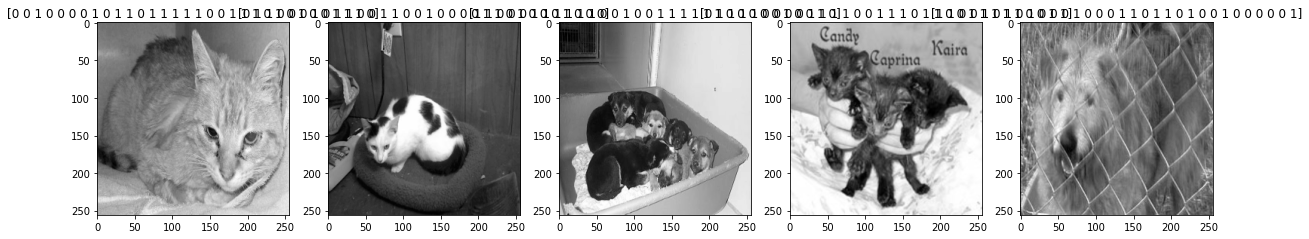


Images after scaling:



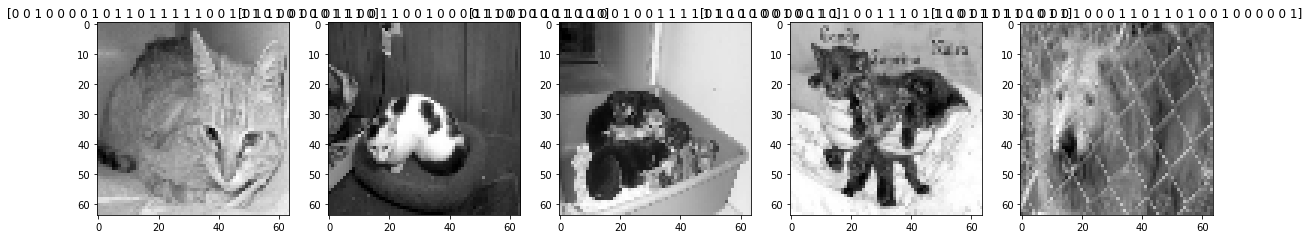

In [ ]:
NEW_SIZE = 64

image_samples = normed.take(5)
samples = list(image_samples.as_numpy_iterator())

print('Images before scaling:\n')

fig, ax = plt.subplots(ncols=len(samples), figsize=(20,20))
for immagine_idx in range(len(samples)):
  ax[immagine_idx].imshow(samples[immagine_idx][0][0,:,:,0], cmap='gray')
  ax[immagine_idx].title.set_text(str(samples[immagine_idx][1]))

plt.show()

print('\nImages after scaling:\n')

fig, ax = plt.subplots(ncols=len(samples), figsize=(20,20))
for immagine_idx in range(len(samples)):
  resized = tf.image.resize(samples[immagine_idx][0][0,:,:,:], (NEW_SIZE, NEW_SIZE))
  ax[immagine_idx].imshow(resized[:,:,0], cmap='gray')
  ax[immagine_idx].title.set_text(str(samples[immagine_idx][1]))

plt.show()

In [ ]:
normed_and_scaled = normed.map(lambda x, y: (tf.image.resize(x, (NEW_SIZE, NEW_SIZE)), y))
normed_and_scaled.as_numpy_iterator().next()[0].shape
len(normed_and_scaled)

773

#Data augmentation

In [ ]:
augmented_rand_right_or_left_flip = normed_and_scaled.map(lambda x, y: (tf.image.random_flip_left_right(x), y))

augmented_rand_up_or_down_flip = augmented_rand_right_or_left_flip.map(lambda x, y: (tf.image.random_flip_up_down(x), y))

half_size = int(len(augmented_rand_up_or_down_flip) / 2)

augmented_to_rotate = augmented_rand_up_or_down_flip.take(half_size)
augmented_rotated = augmented_to_rotate.map(lambda x, y: (tf.image.rot90(x, k=random.randint(0, 3)), y))

augmented_not_rotated = augmented_rand_up_or_down_flip.skip(half_size).take(half_size)

final_preprocessed_dataset = augmented_rotated.concatenate(augmented_not_rotated)

len(final_preprocessed_dataset)

772


Images after random flippings:



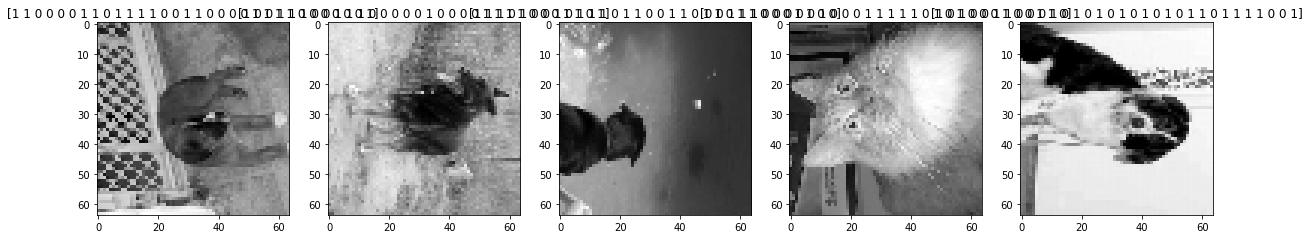

In [ ]:
image_samples = final_preprocessed_dataset.take(5)
samples = list(image_samples.as_numpy_iterator())

print('\nImages after random flippings:\n')

fig, ax = plt.subplots(ncols=len(samples), figsize=(20,20))
for immagine_idx in range(len(samples)):
  resized = tf.image.resize(samples[immagine_idx][0][0,:,:,:], (NEW_SIZE, NEW_SIZE))
  ax[immagine_idx].imshow(resized[:,:,0], cmap='gray')
  ax[immagine_idx].title.set_text(str(samples[immagine_idx][1]))

plt.show()

#Split dataset into train, validation and test

In [ ]:
dataset_size = len(final_preprocessed_dataset)

shuffled_final = final_preprocessed_dataset.shuffle(dataset_size)

training_split = int(0.8 * dataset_size)
validation_split = int(0.2 * dataset_size)

training_set = shuffled_final.take(training_split)
validation_set = shuffled_final.skip(training_split).take(validation_split)

#training_set_lenght = len(training_set)
#training_set_lenght

#Prepare 5-fold validation

In [ ]:

################################
folds_number = 5
test_split = int(0.2 * training_split)
print(test_split)

folds_number = 5
folds_size = int(len(training_set) / 5)
print(folds_size)
###################################

training_folds = []
testing_folds = []

def generate_5_folds_validation_datasets():
  for i in range(folds_number):
    training_fold_datasets = []
    for j in range(folds_number):
      if (i == j):
        testing_folds.append(training_set.skip(i * folds_size).take(folds_size))
        #print(str(len(testing_folds[i])) + ' ' + str(i) + ' ' + str(j))
      elif (i != j):
        dataset = training_set.skip(j * folds_size).take(folds_size)
        training_fold_datasets.append(dataset)
    #print(str(len(training_fold_datasets)))

    training_dataset = training_fold_datasets[0]
    for t in range(len(training_fold_datasets) - 1):
      training_dataset = training_dataset.concatenate(training_fold_datasets[t + 1])
    #print(len(training_dataset))
    training_folds.append(training_dataset.shuffle(len(training_dataset)))

  #print(len(training_folds))
  #print(len(testing_folds))
  #print(len(training_folds[0]))
  #print(len(testing_folds[0]))

generate_5_folds_validation_datasets()

123
123


#CNN

In [ ]:
CNN = tf.keras.models.Sequential([

    # Link to explanation on how to fix it
    # https://stackoverflow.com/questions/47324571/keras-valueerror-negative-dimension-size-caused-by-subtracting-5-from-1                              
    # The error is too much convolution on first layer

    tf.keras.layers.InputLayer(input_shape=(NEW_SIZE, NEW_SIZE, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

CNN.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
    #metrics=['accuracy']
)

CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0

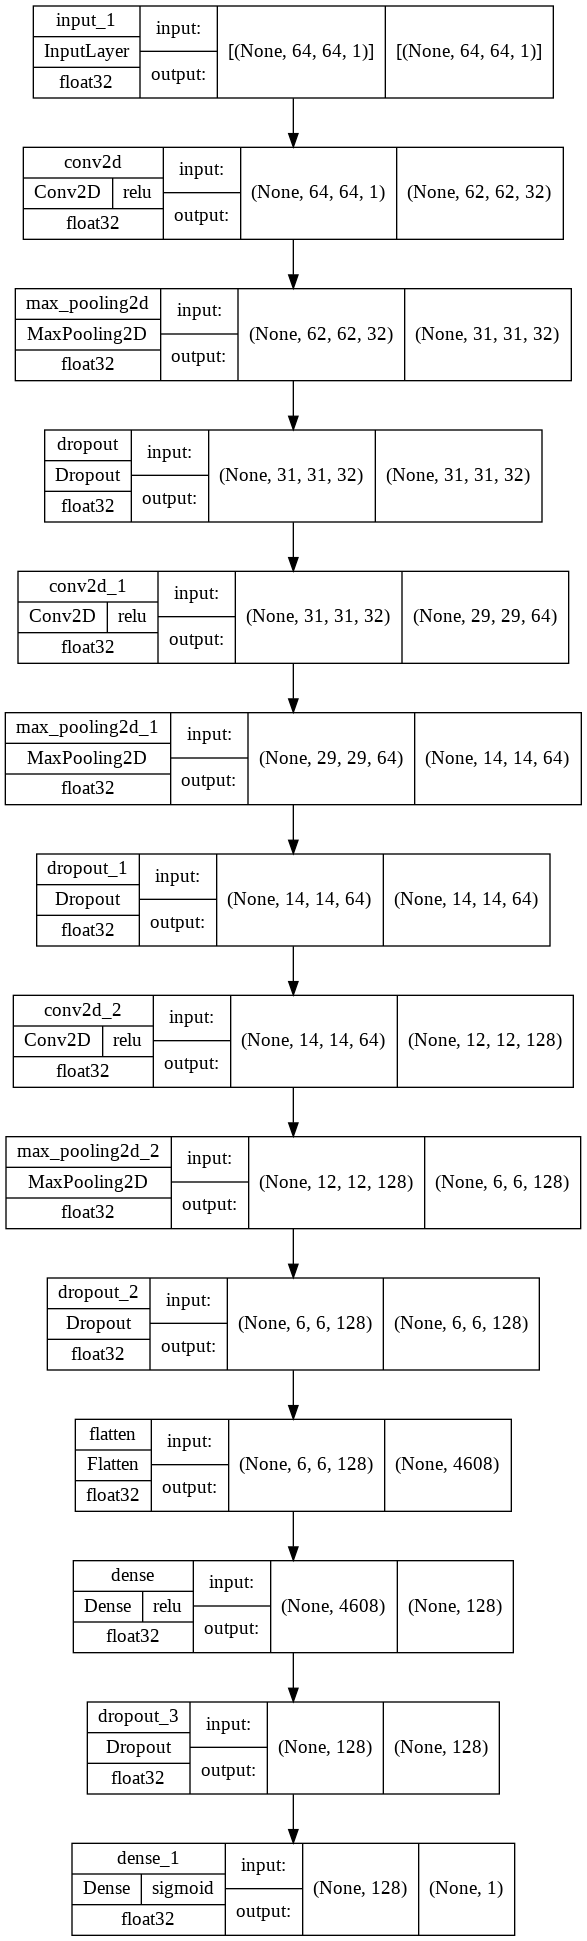

In [ ]:
tf.keras.utils.plot_model(
    CNN,
    to_file='CNN.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    #rankdir='TB',
    #expand_nested=False,
    dpi=96,
    #layer_range=None,
    show_layer_activations=True
)

#Training

In [ ]:
nn_models = []

for i in range(5):
  model = CNN
  nn_models.append(model)

nn_models

In [ ]:
nn_models

all_5_folds_training_results = []
all_5_folds_test_results = []

def training_with_5_fold_cross_validation(models, folds, training_folds_list, testing_folds_list, validation_dataset):
  for i in range(folds):
    tf.keras.backend.clear_session()

    nn_model_for_fold_i = models[i]
    print('\nStarting training on ' + str(i) + '-th fold\n')
    training_result = nn_model_for_fold_i.fit(
        training_folds_list[i],
        epochs=100,
        batch_size=32,
        validation_data=validation_dataset
    )
    all_5_folds_training_results.append(training_result)
    print('\nTraining on ' + str(i) + '-th fold finished\n')
    print('\nStarting testing on ' + str(i) + '-th fold\n')
    testing_result = nn_model_for_fold_i.evaluate(
        testing_folds_list[i],
        batch_size=32
    )
    all_5_folds_test_results.append(testing_result)
    print('\nTesting on ' + str(i) + '-th fold finished\n')

training_with_5_fold_cross_validation(nn_models, folds_number, training_folds, testing_folds, validation_set)


Starting training on 0-th fold

Epoch 1/100
492/492 [==============================] - 400s 163ms/step - loss: 0.6895 - binary_accuracy: 0.5360 - val_loss: 0.6858 - val_binary_accuracy: 0.5700
Epoch 2/100
492/492 [==============================] - 382s 160ms/step - loss: 0.6830 - binary_accuracy: 0.5578 - val_loss: 0.6830 - val_binary_accuracy: 0.5643
Epoch 3/100
492/492 [==============================] - 384s 163ms/step - loss: 0.6696 - binary_accuracy: 0.5897 - val_loss: 0.6643 - val_binary_accuracy: 0.6252
Epoch 4/100
492/492 [==============================] - 386s 160ms/step - loss: 0.6480 - binary_accuracy: 0.6243 - val_loss: 0.6229 - val_binary_accuracy: 0.6542
Epoch 5/100
492/492 [==============================] - 383s 163ms/step - loss: 0.6192 - binary_accuracy: 0.6541 - val_loss: 0.5968 - val_binary_accuracy: 0.6857
Epoch 6/100
492/492 [==============================] - 382s 163ms/step - loss: 0.5954 - binary_accuracy: 0.6795 - val_loss: 0.5783 - val_binary_accuracy: 0.6970
E

In [ ]:
for index in range(5):

  training_history = all_5_folds_training_results[index]

  print('\nTraining results for ' + str(i) + '-th fold:\n')

  fig = plt.figure()
  plt.plot(training_history.history['loss'], color='teal', label='loss')
  plt.plot(training_history.history['val_loss'], color='orange', label='val_loss')
  fig.suptitle('Loss', fontsize=20)
  plt.legend(loc="upper left")
  plt.show()

  fig = plt.figure()
  plt.plot(training_history.history['binary_accuracy'], color='teal', label='binary_accuracy')
  plt.plot(training_history.history['val_binary_accuracy'], color='orange', label='val_binary_accuracy')
  fig.suptitle('Accuracy', fontsize=20)
  plt.legend(loc="upper left")
  plt.show()

  test_history = all_5_folds_test_results[index]

  print('\nTesting results for ' + str(i) + '-th fold:\n')

  print(test_history)

  fig = plt.figure()
  plt.plot(test_history.history['loss'], color='teal', label='loss')
  plt.plot(test_history.history['binary_accuracy'], color='orange', label='binary_accuracy')
  fig.suptitle('Loss', fontsize=20)
  plt.legend(loc="upper left")
  plt.show()
